In [1]:
#!pip install mapie

In [2]:
#!pip install xgboost

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from mapie.classification import MapieClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')

In [55]:
data = pd.read_parquet('../data/interim/meteorological_data_with_outages.parquet')

In [56]:
data.columns

Index(['time', 'T2M', 'ALLSKY_SFC_SW_DWN', 'PS', 'WS50M', 'ALLSKY_SFC_LW_DWN',
       'WD50M', 'PRECTOTCORR', 'GWETPROF', 'CLRSKY_SFC_SW_DWN', 'QV10M',
       'RHOA', 'T10M', 'TO3', 'TQV', 'Z0M', 'TOA_SW_DWN', 'RH2M', 'WS2M',
       'CLRSKY_SFC_LW_DWN', 'DISPH', 'episode_fips_id',
       'meteorological_current_datetime_val', 'day_of_year', 'hour_of_day',
       'day_of_week', 'month_of_year', 'coord0', 'coord1', 'coord2',
       'hours_to_outage', 'outage_in_an_hour'],
      dtype='object')

In [57]:
data.sort_values(by=['episode_fips_id', 'meteorological_current_datetime_val'], inplace=True)
data.head()

,time,T2M,ALLSKY_SFC_SW_DWN,PS,WS50M,ALLSKY_SFC_LW_DWN,WD50M,PRECTOTCORR,GWETPROF,CLRSKY_SFC_SW_DWN,...,meteorological_current_datetime_val,day_of_year,hour_of_day,day_of_week,month_of_year,coord0,coord1,coord2,hours_to_outage,outage_in_an_hour
episode_fips_time_id,,,,,,,,,,,,,,,,,,,,,
100009_55009_2015081411,2015081411,31.06,815.92,99.03,6.17,407.52,293.9,1.69,0.62,838.92,...,2015-08-14 11:00:00,226,11,4,8,-88.004,44.452,223.21,11.0,0
100009_55009_2015081412,2015081412,31.48,800.83,99.00,6.42,411.45,294.3,2.84,0.62,836.10,...,2015-08-14 12:00:00,226,12,4,8,-88.004,44.452,223.21,10.0,0
100009_55009_2015081413,2015081413,31.57,639.47,98.97,6.70,419.52,296.0,5.70,0.61,783.12,...,2015-08-14 13:00:00,226,13,4,8,-88.004,44.452,223.21,9.0,0
100009_55009_2015081414,2015081414,31.37,343.15,98.95,6.92,446.12,298.4,8.90,0.61,680.40,...,2015-08-14 14:00:00,226,14,4,8,-88.004,44.452,223.21,8.0,0
100009_55009_2015081415,2015081415,30.69,123.62,98.94,7.12,429.02,299.7,10.35,0.61,536.53,...,2015-08-14 15:00:00,226,15,4,8,-88.004,44.452,223.21,7.0,0


In [58]:
no_delta_cols = [
    'time', 
    'episode_fips_id',
    'meteorological_current_datetime_val', 
    'outage_in_an_hour', 
    'hours_to_outage',
    'day_of_year', 
    'hour_of_day', 
    'day_of_week',
    'month_of_year',
    'coord0', 
    'coord1',
    'coord2',
]

data['abs_diff_between_t2m_t10m'] = data['T2M'] - data['T10M']
data['abs_diff_between_ws50m_wd2m'] = data['WS50M'] - data['WS2M']
for col in data.columns:
    if col not in no_delta_cols:
        data[f'{col}_an_hour_ago'] = data.groupby('episode_fips_id')[col].shift(1)
        data[f'{col}_two_hours_ago'] = data.groupby('episode_fips_id')[col].shift(2)
        data[f'{col}_three_hours_ago'] = data.groupby('episode_fips_id')[col].shift(3)
        data[f'{col}_delta_one_hour'] = data[col] - data[f'{col}_an_hour_ago']
        data[f'{col}_delta_two_hour'] = data[col] - data[f'{col}_two_hours_ago']
        data[f'{col}_delta_three_hour'] = data[col] - data[f'{col}_three_hours_ago']
        data[f'{col}_delta_previous'] = data[f'{col}_an_hour_ago'] - data[f'{col}_two_hours_ago']

In [59]:
data

,time,T2M,ALLSKY_SFC_SW_DWN,PS,WS50M,ALLSKY_SFC_LW_DWN,WD50M,PRECTOTCORR,GWETPROF,CLRSKY_SFC_SW_DWN,...,abs_diff_between_t2m_t10m_delta_two_hour,abs_diff_between_t2m_t10m_delta_three_hour,abs_diff_between_t2m_t10m_delta_previous,abs_diff_between_ws50m_wd2m_an_hour_ago,abs_diff_between_ws50m_wd2m_two_hours_ago,abs_diff_between_ws50m_wd2m_three_hours_ago,abs_diff_between_ws50m_wd2m_delta_one_hour,abs_diff_between_ws50m_wd2m_delta_two_hour,abs_diff_between_ws50m_wd2m_delta_three_hour,abs_diff_between_ws50m_wd2m_delta_previous
episode_fips_time_id,,,,,,,,,,,,,,,,,,,,,
100009_55009_2015081411,2015081411,31.06,815.92,99.03,6.17,407.52,293.9,1.69,0.62,838.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009_55009_2015081412,2015081412,31.48,800.83,99.00,6.42,411.45,294.3,2.84,0.62,836.10,...,NaN,NaN,NaN,2.68,NaN,NaN,0.12,NaN,NaN,NaN
100009_55009_2015081413,2015081413,31.57,639.47,98.97,6.70,419.52,296.0,5.70,0.61,783.12,...,-0.14,NaN,-0.07,2.80,2.68,NaN,0.16,0.28,NaN,0.12
100009_55009_2015081414,2015081414,31.37,343.15,98.95,6.92,446.12,298.4,8.90,0.61,680.40,...,-0.20,-0.27,-0.07,2.96,2.80,2.68,0.15,0.31,0.43,0.16
100009_55009_2015081415,2015081415,30.69,123.62,98.94,7.12,429.02,299.7,10.35,0.61,536.53,...,-0.23,-0.30,-0.13,3.11,2.96,2.80,0.18,0.33,0.49,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992_55105_2015091801,2015091801,21.45,0.00,97.79,6.96,397.35,221.4,89.98,0.59,0.00,...,0.04,0.11,0.02,4.82,5.40,6.26,-0.52,-1.10,-1.96,-0.58
99992_55105_2015091802,2015091802,21.43,0.00,97.76,5.75,398.52,242.1,87.26,0.59,0.00,...,0.00,0.02,0.02,4.30,4.82,5.40,-0.39,-0.91,-1.49,-0.52
99992_55105_2015091803,2015091803,21.34,0.00,97.75,5.17,386.92,271.6,72.51,0.60,0.00,...,-0.05,-0.03,-0.02,3.91,4.30,4.82,-0.20,-0.59,-1.11,-0.39


In [61]:
# data['abs_diff_between_t2m_t10m'] = data.apply(lambda row: row['T2M'] - row['T10M'], axis=1)
# data['abs_diff_between_ws50m_wd2m'] = data.apply(lambda row: row['WS50M'] - row['WS2M'], axis=1)
# no_delta_cols = ['time', 'episode_fips_id', 'meteorological_current_datetime_val', 'outage_in_an_hour', 'hours_to_outage']
# for col in data.columns:
#     if col not in no_delta_cols:
#         data[f'{col}_an_hour_ago'] = data.groupby('episode_fips_id')[col].shift(1)
#         data[f'{col}_two_hours_ago'] = data.groupby('episode_fips_id')[col].shift(2)
#         data[f'{col}_three_hours_ago'] = data.groupby('episode_fips_id')[col].shift(3)
#         data[f'{col}_delta_one_hour'] = data.apply(lambda row: row[col] - row[f'{col}_an_hour_ago'], axis=1)
#         data[f'{col}_delta_two_hour'] = data.apply(lambda row: row[col] - row[f'{col}_two_hours_ago'], axis=1)
#         data[f'{col}_delta_three_hour'] = data.apply(lambda row: row[col] - row[f'{col}_three_hours_ago'], axis=1)
#         data[f'{col}_delta_previous'] = data.apply(lambda row: row[f'{col}_an_hour_ago'] - row[f'{col}_two_hours_ago'], axis=1)
#         data[f'{col}_delta_two_previous'] = data.apply(lambda row: row[f'{col}_two_hours_ago'] - row[f'{col}_three_hours_ago'], axis=1)
#         data[f'{col}_previous_tendency'] = data[f'{col}_delta_previous'].apply(lambda x: 1 if x> 0 else  (-1 if x <0 else 0))
#         data[f'{col}_two_previous_tendency'] = data[f'{col}_delta_two_previous'].apply(lambda x: 1 if x> 0 else  (-1 if x <0 else 0))
#         data[f'{col}_current_tendency'] = data[f'{col}_delta_one_hour'].apply(lambda x: 1 if x> 0 else  (-1 if x <0 else 0))

In [62]:
data.dropna(subset=['T2M_three_hours_ago'], inplace=True)

In [63]:
train_episode_fips_id, test_episode_fips_id = train_test_split(
    data.episode_fips_id.unique(), train_size=0.7, random_state=42
)

train_episode_fips_id, cal_episode_fips_id = train_test_split(
    train_episode_fips_id, train_size=0.9, random_state=42
)

In [64]:
drop_cols = ['time', 'episode_fips_id', 'meteorological_current_datetime_val', 'hours_to_outage']

data_train = data[data.episode_fips_id.isin(train_episode_fips_id)].drop(drop_cols, axis=1)
data_test = data[data.episode_fips_id.isin(test_episode_fips_id)].drop(drop_cols, axis=1)
data_cal = data[data.episode_fips_id.isin(cal_episode_fips_id)].drop(drop_cols, axis=1)

In [65]:
x_train, y_train = data_train.drop('outage_in_an_hour', axis=1), data_train.outage_in_an_hour
x_test, y_test = data_test.drop('outage_in_an_hour', axis=1), data_test.outage_in_an_hour
x_cal, y_cal = data_cal.drop('outage_in_an_hour', axis=1), data_cal.outage_in_an_hour

In [66]:
#import numpy as np

In [67]:
#len(np.where(y_train == 0)[0])

In [68]:
#from collections import Counter

#neg, pos = Counter(y_train).values()
neg, pos = sum(y_train==0), sum(y_train==1)
scale_pos_weight = neg / pos
scale_pos_weight

32.93425133358144

In [69]:
model = RandomForestClassifier(
    n_estimators=500, 
    max_depth=4, 
    class_weight='balanced',
    ccp_alpha=0.001, 
)

In [70]:
model = XGBClassifier(
    n_estimators=800,          
    max_depth=4,          
    scale_pos_weight=scale_pos_weight,  
    use_label_encoder=False,   
    objective='binary:logistic',
    eval_metric='aucpr',
    reg_lambda=1,
    subsample=0.75,
    colsample_bytree=0.75
          
)

In [71]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

In [72]:
pred_test = pd.Series(model.predict_proba(x_test)[:, 1])
pred_test.index = x_test.index

pred_train = pd.Series(model.predict_proba(x_train)[:, 1])
pred_train.index = x_train.index

In [73]:
roc_auc_score(y_train, pred_train), roc_auc_score(y_test, pred_test)

(np.float64(0.9797350224305531), np.float64(0.8731632825185315))

In [38]:
#roc_auc_score(y_train, pred_train), roc_auc_score(y_test, pred_test)

(np.float64(0.9800148982542072), np.float64(0.8735124768380447))

In [74]:
precision, recall, _ = precision_recall_curve(y_train, pred_train)
auc(recall, precision)

np.float64(0.5282709913126886)

In [75]:
precision, recall, _ = precision_recall_curve(y_test, pred_test)
auc(recall, precision)

np.float64(0.2580605274809443)

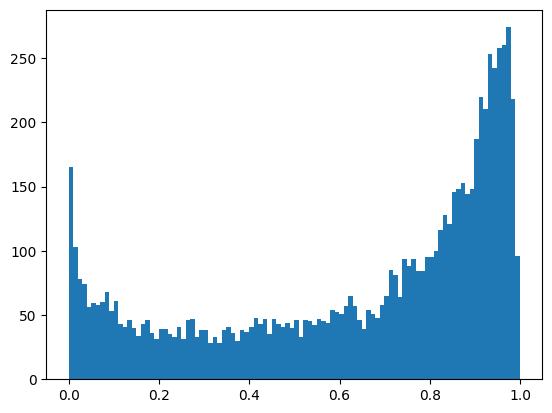

In [76]:
plt.hist(pred_test[y_test==1],bins=100)
plt.show()

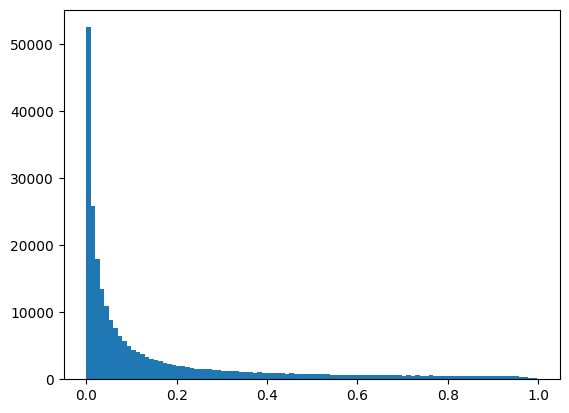

In [77]:
plt.hist(pred_test[y_test==0], bins=100)
plt.show()

In [78]:
#response_var = pd.read_parquet('../data/interim/storm_outages_2014_2023.parquet')

In [79]:
#sample_id = pd.Series(train_episode_fips_id).sample(1).iloc[0]
#sample_data = data[data.episode_fips_id==sample_id]
#sample_data['pred'] = pred_train

In [80]:
#sample_data

In [81]:
#pred_train.index.value_counts()

In [82]:
#data.loc['164119_06029_2021120823']

In [83]:
import shap

In [84]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

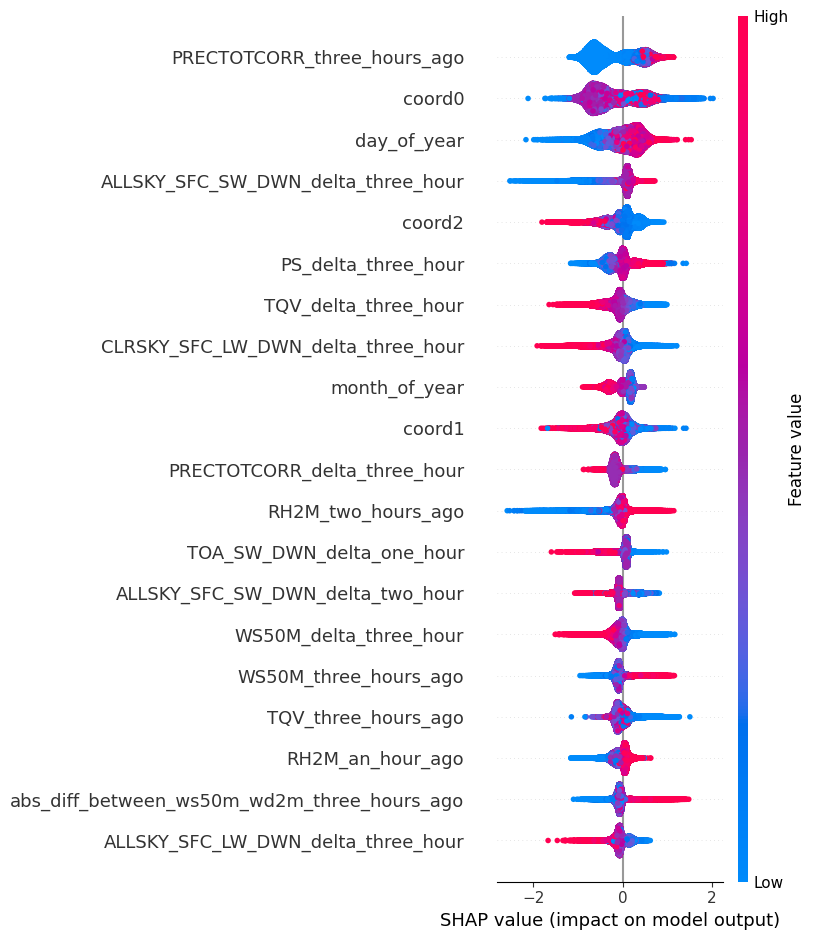

In [85]:
shap.summary_plot(shap_values, x_test)

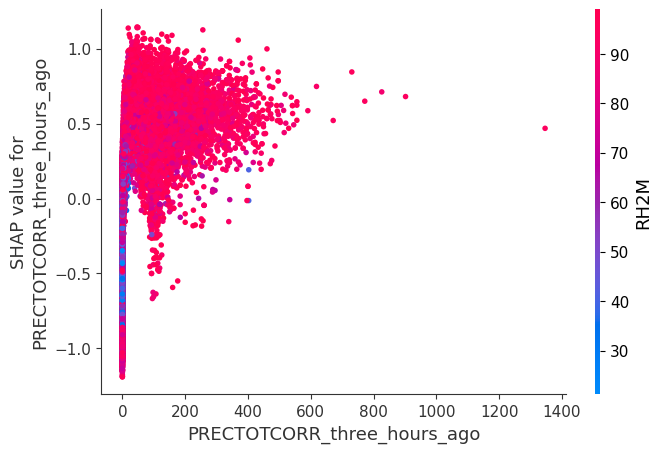

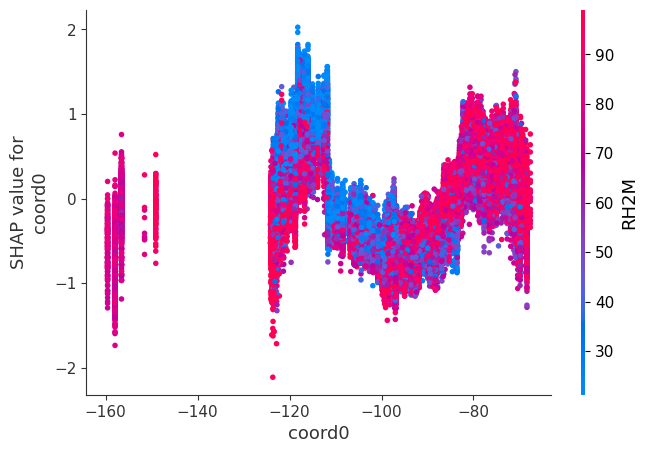

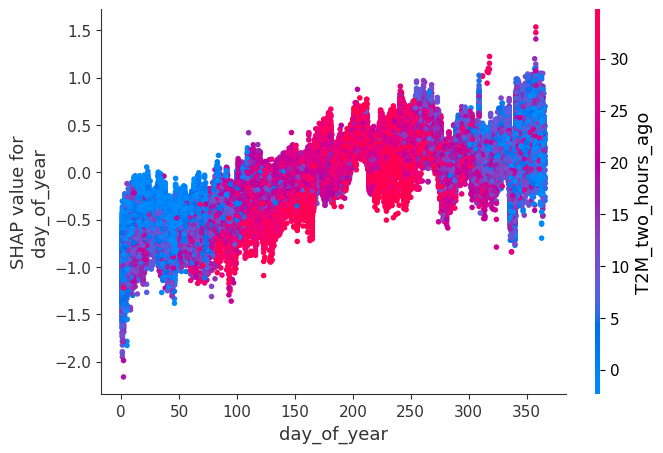

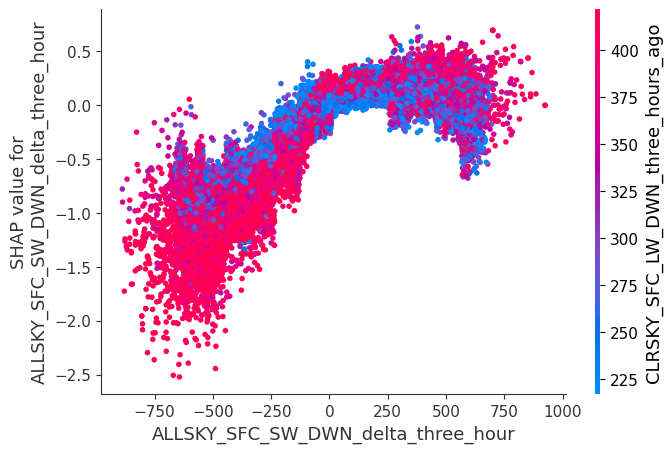

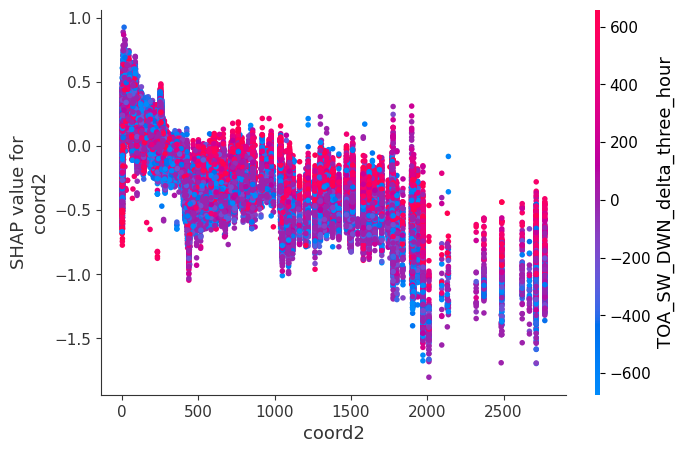

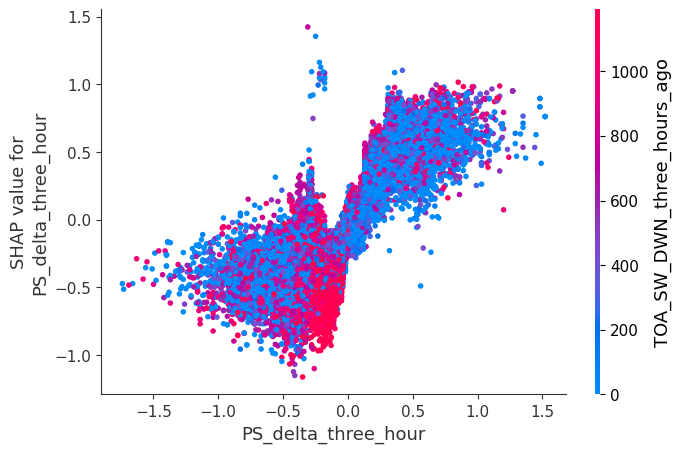

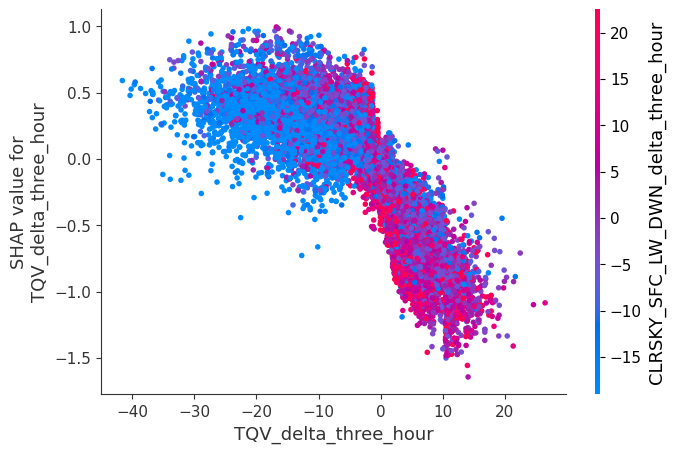

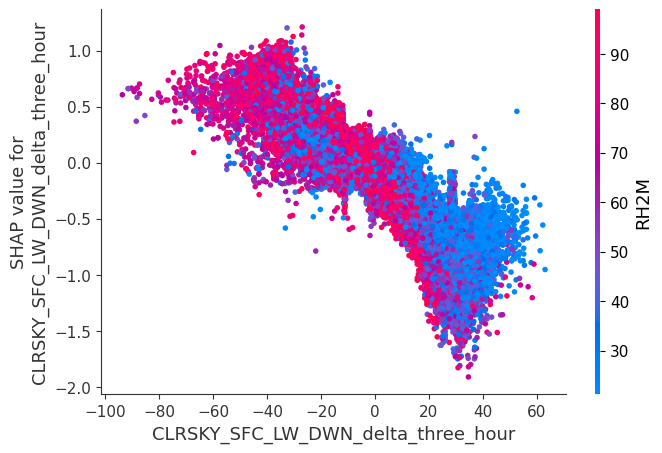

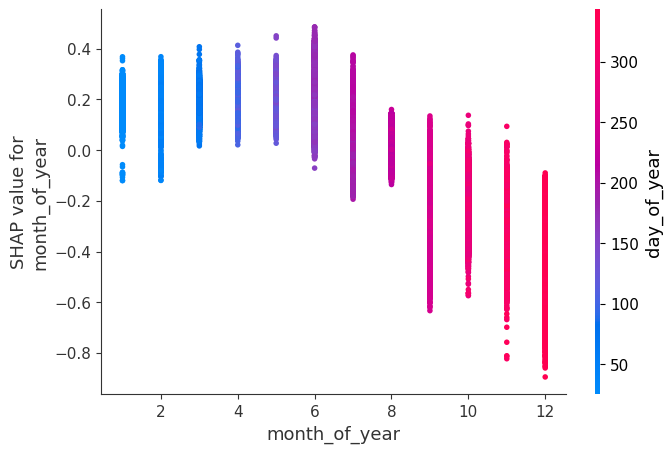

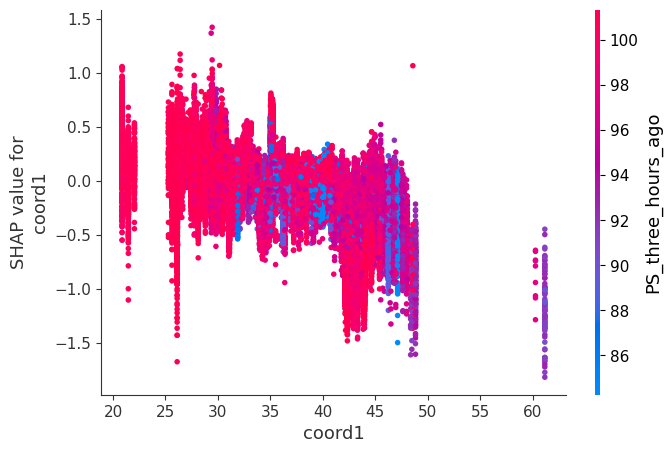

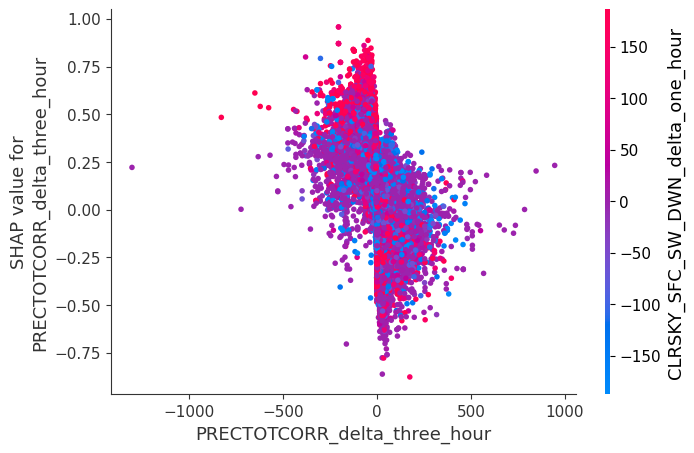

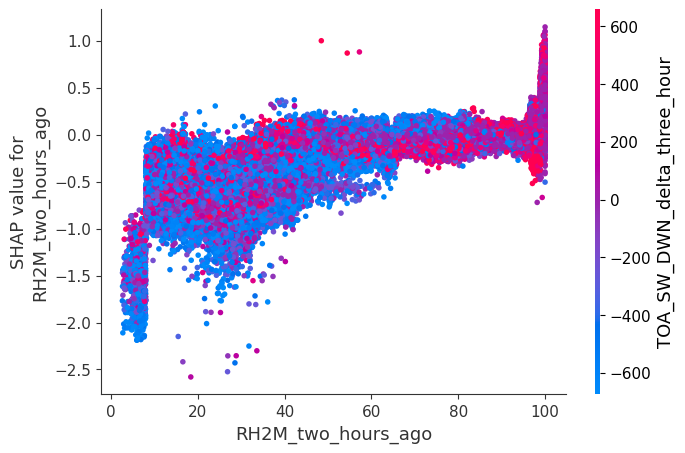

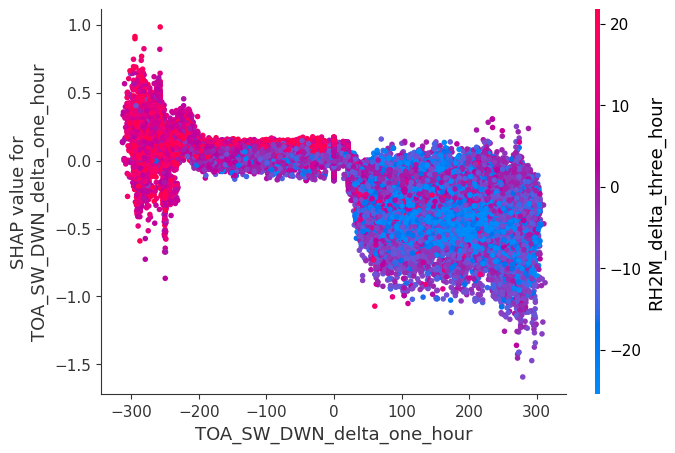

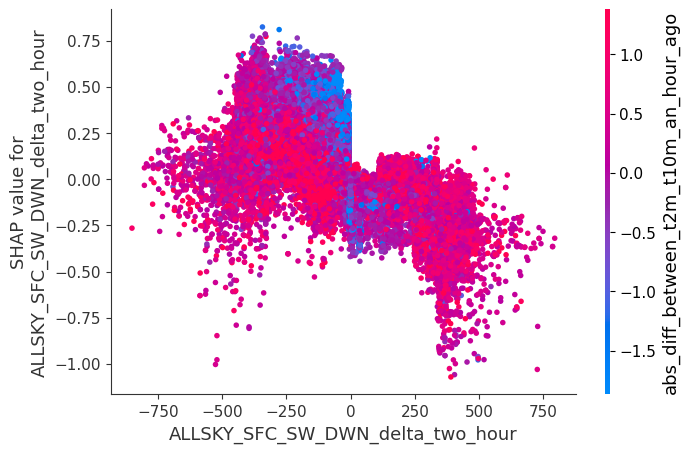

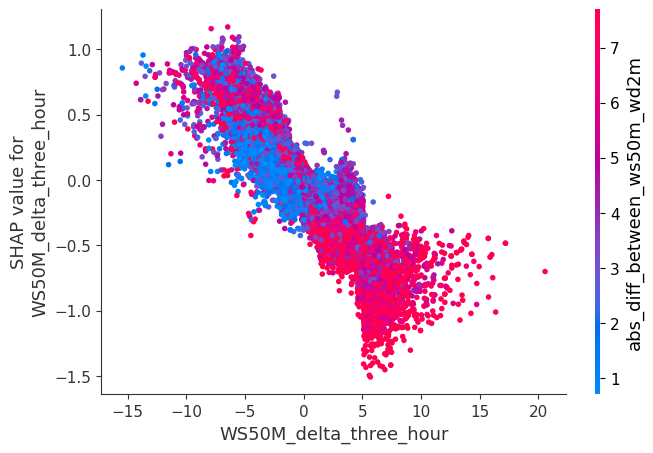

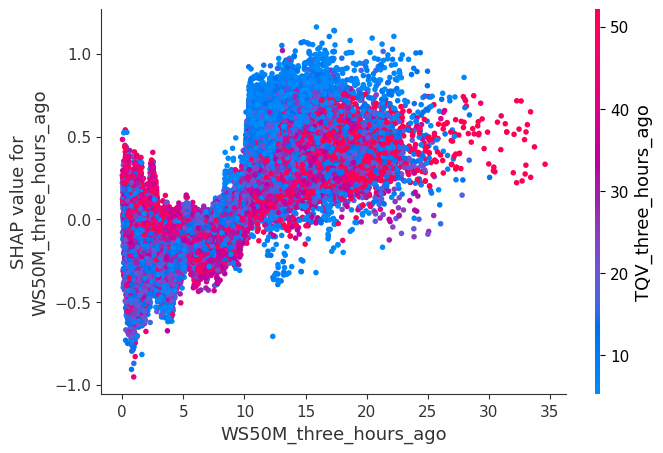

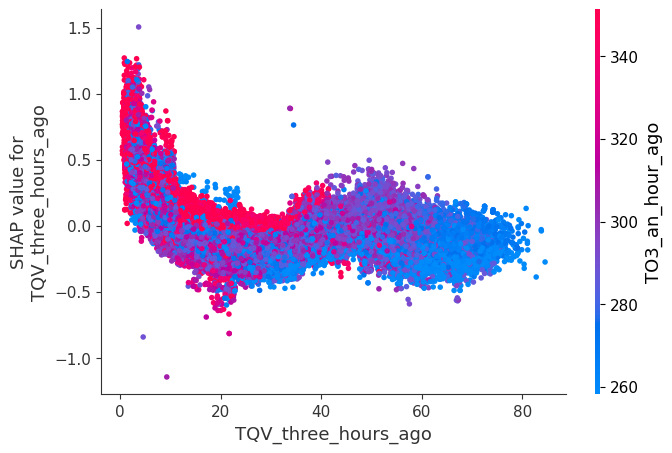

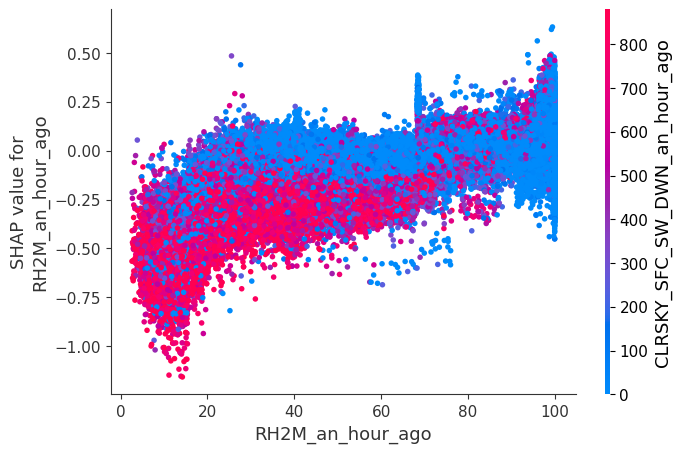

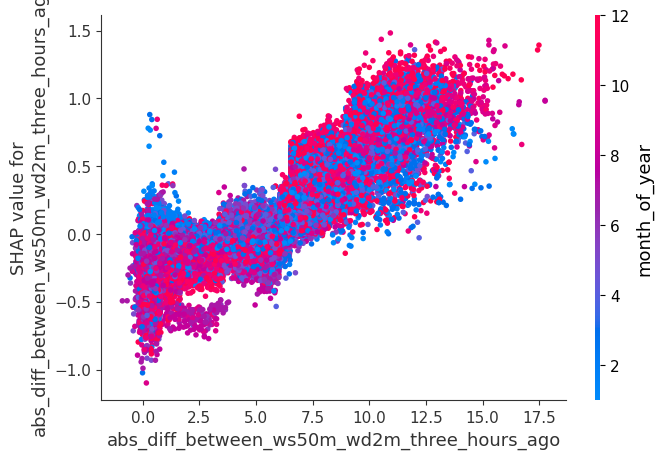

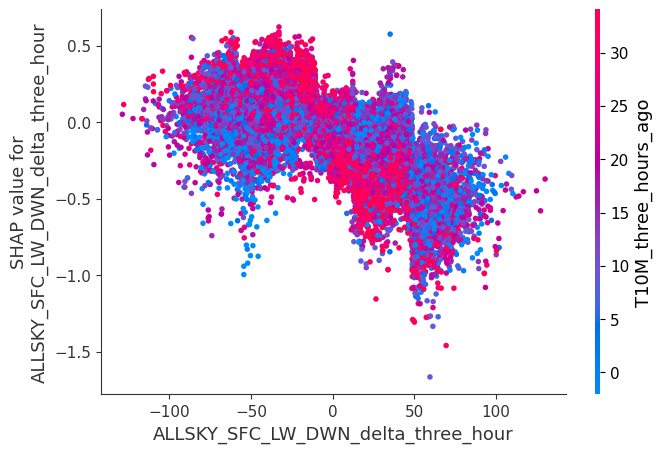

In [90]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, x_test)


In [92]:
shap_df = pd.DataFrame(shap_values, index=x_test.index, columns=x_test.columns)

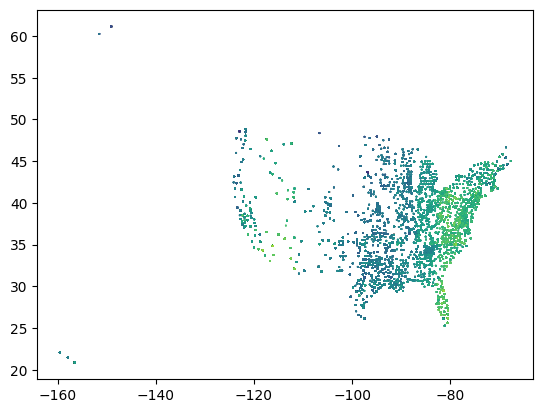

In [99]:
plt.scatter(x_test.coord0, x_test.coord1, s=0.1, c=shap_df.coord0 + shap_df.coord1)
#shap_df.coord0

In [114]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="score")
mapie_score.fit(x_cal, y_cal)

MapieClassifier(cv='prefit',
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.75, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='aucpr', feature_types=None,
                                        feature_weights=None, gamma=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=4,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=800,
                                        n_jobs=None, num_parallel_tree=None, ...),
                method='score')

In [143]:
alpha = 0.05
y_pred_score, y_ps_score = mapie_score.predict(x_test, alpha=alpha)


In [144]:
pred_test

episode_fips_time_id
100009_55009_2015081414    0.001301
100009_55009_2015081415    0.003854
100009_55009_2015081416    0.033195
100009_55009_2015081417    0.478795
100009_55009_2015081418    0.095052
                             ...   
99962_34029_2015100109     0.203881
99962_34029_2015100110     0.166751
99962_34029_2015100111     0.186619
99962_34029_2015100112     0.237993
99962_34029_2015100113     0.309396
Length: 257183, dtype: float32

In [145]:
mapie_score.quantiles_

array([0.7588968], dtype=float32)

In [156]:
mapie_score.conformity_scores_

array([[0.01425666],
       [0.01395696],
       [0.00557792],
       ...,
       [0.35424894],
       [0.5716263 ],
       [0.5787226 ]], shape=(64158, 1), dtype=float32)

In [147]:
mapie_score

array([0, 0, 0, ..., 0, 0, 0], shape=(257183,))

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], shape=(257183, 1))

In [155]:
y_analisis = pd.DataFrame()
y_analisis['y_test'] = y_test
y_analisis['y_pred'] = pred_test
y_analisis['y_is_uncertain'] = y_ps_score.sum(axis=1)-1


In [171]:
y_analisis['q'] = pd.qcut(y_analisis.y_pred, q=50)

<Axes: xlabel='q'>

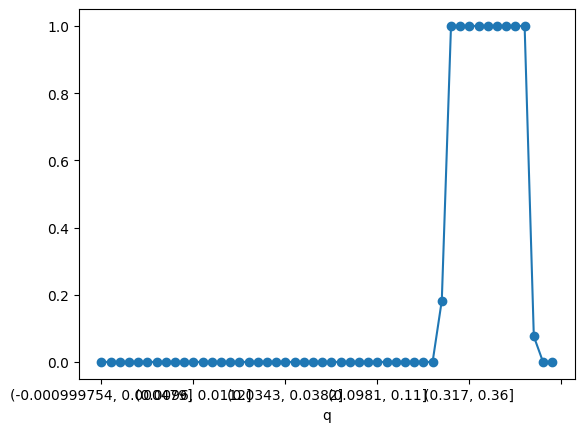

In [172]:
y_analisis.groupby('q').y_is_uncertain.mean().plot(marker='o')

In [4]:
help(classification_coverage_score)

Help on function classification_coverage_score in module mapie.metrics:

classification_coverage_score(y_true: Union[numpy._typing._array_like._Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[bool | int | float | complex | str | bytes]], y_pred_set: Union[numpy._typing._array_like._Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[bool | int | float | complex | str | bytes]]) -> float
    Effective coverage score obtained by the prediction sets.
    
    The effective coverage is obtained by estimating the fraction
    of true labels that lie within the prediction set

In [5]:
help(classification_mean_width_score)

Help on function classification_mean_width_score in module mapie.metrics:

classification_mean_width_score(y_pred_set: Union[numpy._typing._array_like._Buffer, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[bool | int | float | complex | str | bytes]]) -> float
    Mean width of prediction set output by
    :class:`~mapie.classification.MapieClassifier`.
    
    Parameters
    ----------
    y_pred_set: ArrayLike of shape (n_samples, n_class)
        Prediction sets given by booleans of labels.
    
    Returns
    -------
    float
        Mean width of the prediction set.
    
    Examples
    --------
    >>> from mapie.metrics import classification_mean_width_score
    >>> import numpy as np
    >>> y_pred_set = np.array([
    ...     [False, False,  True,  True],
    ...     [

In [3]:
from mapie.metrics import classification_coverage_score, classification_mean_width_score


In [183]:
alpha2 = np.arange(0.02, 0.98, 0.02)
_, y_ps_score2 = mapie_score.predict(x_test, alpha=alpha2)
coverages_score = [
    classification_coverage_score(y_test, y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_score = [
    classification_mean_width_score(y_ps_score2[:, :, i]) for i, _ in enumerate(alpha2)
]


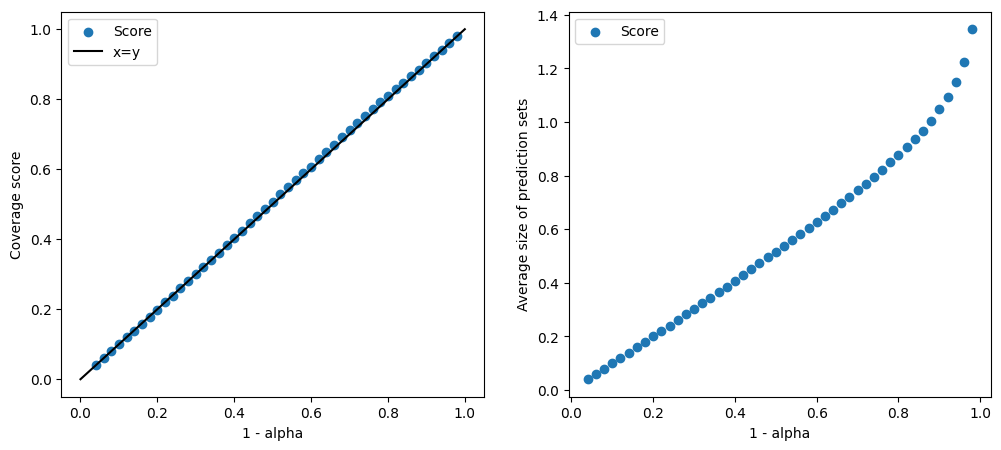

In [184]:
def plot_coverages_widths(alpha, coverage, width, method):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(1 - alpha, coverage, label=method)
    axs[0].set_xlabel("1 - alpha")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([0, 1], [0, 1], label="x=y", color="black")
    axs[0].legend()
    axs[1].scatter(1 - alpha, width, label=method)
    axs[1].set_xlabel("1 - alpha")
    axs[1].set_ylabel("Average size of prediction sets")
    axs[1].legend()
    plt.show()


plot_coverages_widths(alpha2, coverages_score, widths_score, "Score")
